<a href="https://colab.research.google.com/github/ryan73093/kaggle-sklearn/blob/main/classifier_heart_failure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
# %matplotlib inline
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import random
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')##出現提示欄進行授權
os.chdir('/content/drive/My Drive/Colab Notebooks/kaggle-sklearn') #切換該目錄
os.listdir() #確認目錄內容

Mounted at /content/drive


['libs',
 'data',
 'catboost_info',
 'sklearn_classifier.ipynb',
 'sklearn_regression.ipynb',
 '.gitignore',
 'classifier_heart_failure.ipynb',
 'Predicting_Churn_for_Bank_Customers.ipynb']

In [3]:
df_set = pd.read_csv('data/heart_failure_clinical_records_dataset.csv')
print(df_set.head())

    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2       

In [4]:
TARGET='DEATH_EVENT'

df_feature=df_set.drop(columns=[TARGET])
df_target=df_set[TARGET]
df=pd.concat([df_feature,df_target],axis=1)
print(df.head())

    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2       

## Analysis

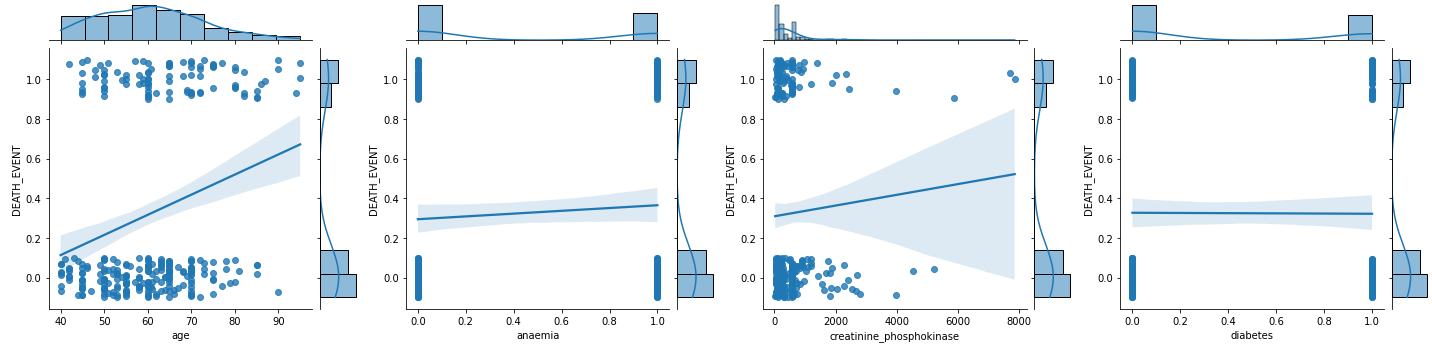

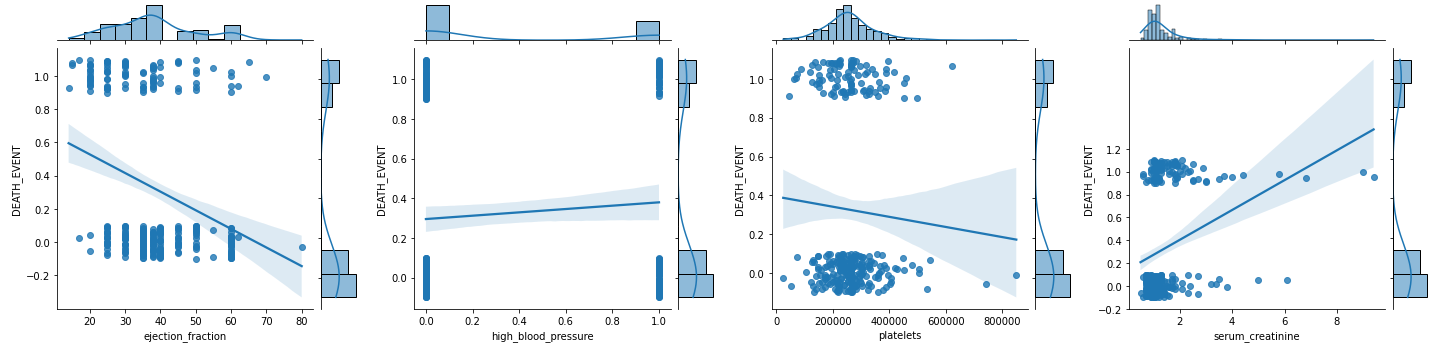

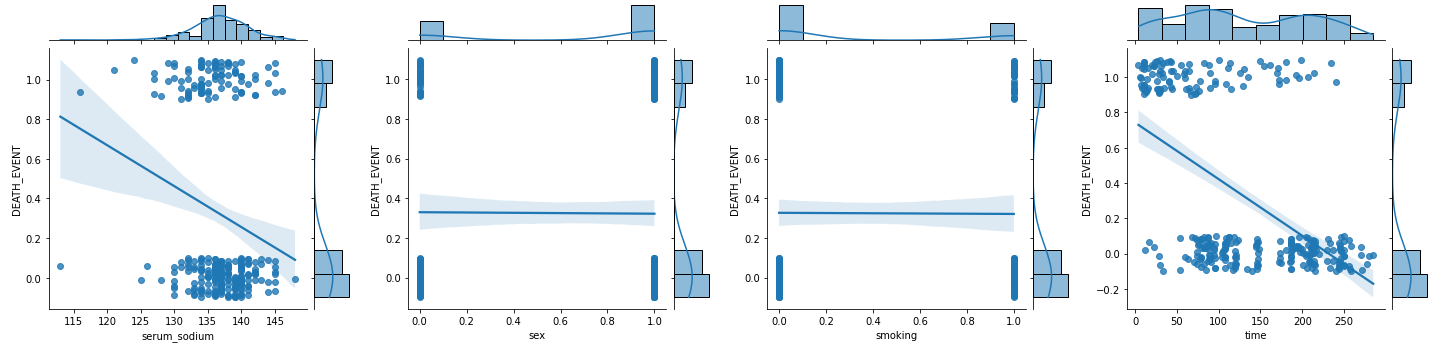

In [5]:
from libs.SeabornFig2Grid import SeabornFig2Grid
import matplotlib.gridspec as gridspec
#增強資料可視性
lst_tmp=[]
for i in range(len(df)):
  lst_tmp.append(random.uniform(-0.1,0.1))
df_plt=df.copy()
df_plt[TARGET]=df[TARGET]+lst_tmp
#繪製
for i in range(math.ceil(len(df_feature.columns)/4)):
  fig=plt.figure(figsize=(20,5))
  gs=gridspec.GridSpec(1, 4)
  for j in range(4):
    try:
      fig_tmp=sns.jointplot(x=list(df_feature)[(4*i+j)],y=TARGET,data=df_plt,kind='reg')
      mg=SeabornFig2Grid(fig_tmp, fig, gs[j])
    except IndexError:
      continue     
  gs.tight_layout(fig)
  plt.show()

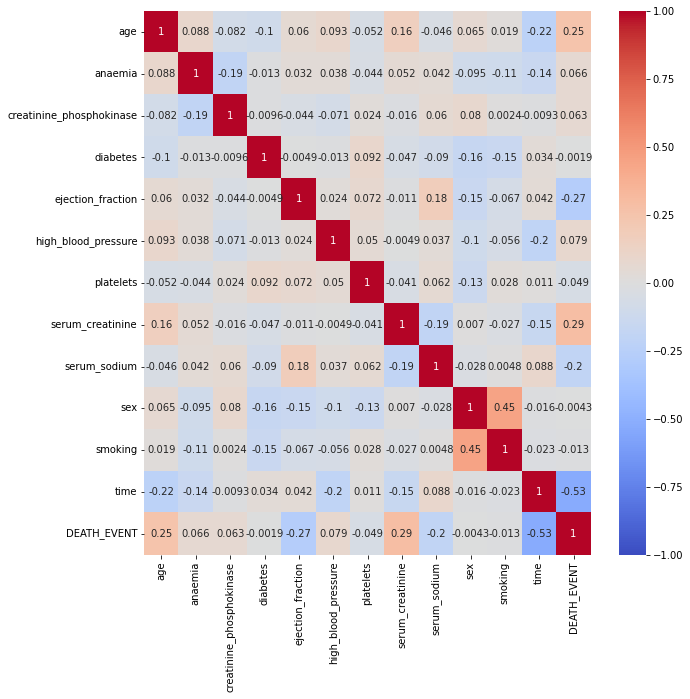

In [6]:
plt.figure(figsize=(10,10))
sns.heatmap(df_set.corr(), vmin=-1, cmap='coolwarm', annot=True)

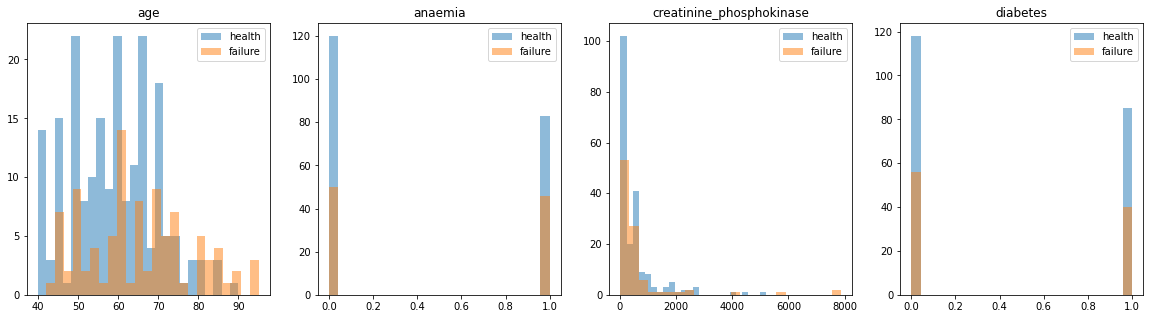

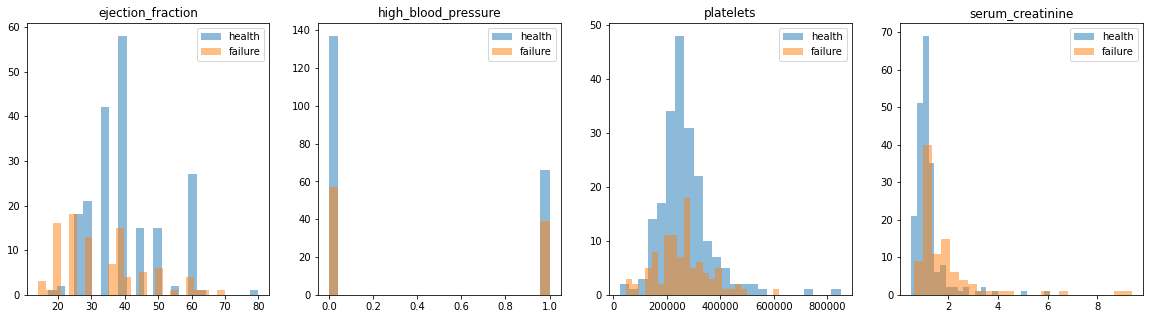

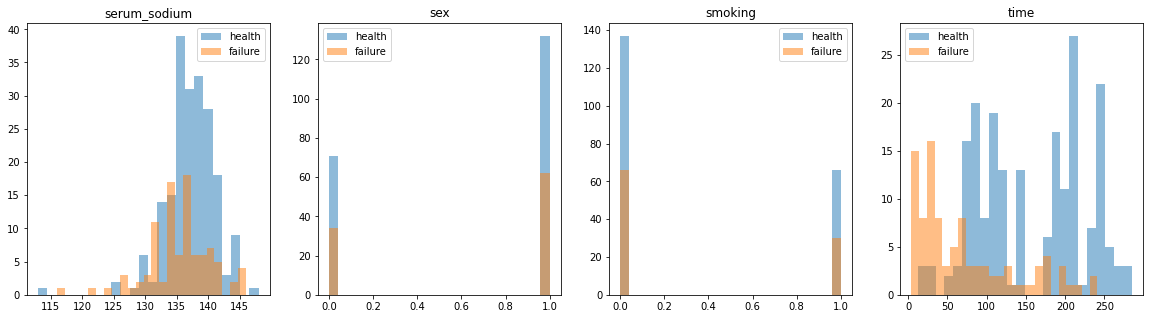

In [7]:
df_failure = df[df[TARGET] == 1]
df_health = df[df[TARGET] == 0]

lst_df_columns = df_feature.columns
for i in range(math.ceil(len(lst_df_columns)/4)):
  fig=plt.figure(figsize=(20,5))
  for j in range(4):
    try:
      plt.subplot(1, 4, j+1)
      plt.hist(df_health[lst_df_columns[4*i+j]],bins=24,alpha=0.5)
      plt.hist(df_failure[lst_df_columns[4*i+j]],bins=24,alpha=0.5)
      plt.title(lst_df_columns[4*i+j])
      plt.legend(['health','failure'])
    except IndexError:
      continue     
  plt.show()

## Feature Select

In [8]:
df=df[['ejection_fraction','serum_creatinine','time',TARGET]]
print(df.head())

   ejection_fraction  serum_creatinine  time  DEATH_EVENT
0                 20               1.9     4            1
1                 38               1.1     6            1
2                 20               1.3     7            1
3                 20               1.9     7            1
4                 20               2.7     8            1


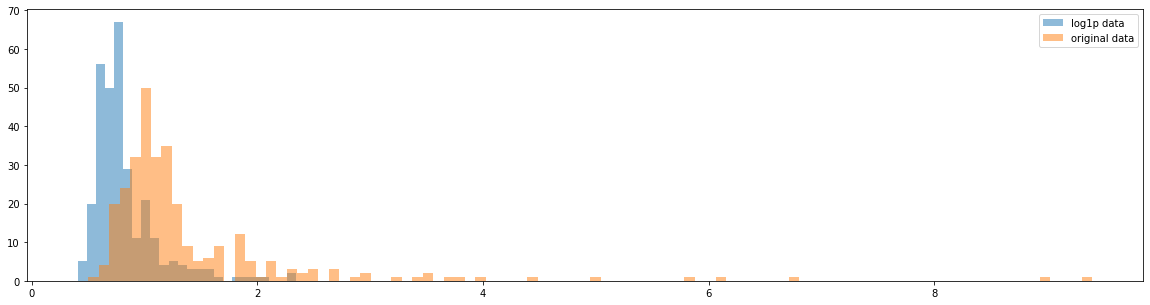

In [9]:
df_normal = df.copy()
df_normal['serum_creatinine'] = np.log1p(df_normal['serum_creatinine']) 
fig=plt.figure(figsize=(20,5))
plt.hist(df_normal['serum_creatinine'],bins=24,alpha=0.5)
plt.hist(df['serum_creatinine'],bins=96,alpha=0.5)
plt.legend(['log1p data','original data'])
plt.show()

## Training Prepare

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
def training(df,method,scaler=None,fig_amount_show=100):
    # Training set & Testing set
    X = df[df.columns[:-1]].values
    Y = df[df.columns[-1]].values
    classifier = method
    if scaler=='minmax':
        sc = MinMaxScaler()
        sc.fit(X)
        X = sc.transform(X)
    elif scaler=='std':
        sc = StandardScaler()
        sc.fit(X)
        X = sc.transform(X)
    else:
        X = X
    train_X,test_X,train_Y,test_Y=train_test_split(X,Y,test_size=0.3, random_state=0)

    classifier.fit(train_X, train_Y)
    print(classifier.fit(train_X, train_Y))

    pred_Y = classifier.predict(test_X)
    test_prob=np.ravel(classifier.predict_proba(test_X)[:,[1]])
    df_pred = pd.DataFrame({'Actual': test_Y, 'Predicted': pred_Y,'Probability':test_prob}).round(3)
    df_pred['Error']=df_pred['Predicted']-df_pred['Actual']
    try:
      df_pred=df_pred.iloc[random.sample(df_pred.index.tolist(), fig_amount_show)] 
    except ValueError:
      print("Your data is smaller than fig_amount_show's setting. ")
    df_pred=df_pred.sort_values(by='Actual').reset_index(drop=True)   
    max_value=max([df_pred['Actual'].max(),df_pred['Predicted'].max()])
    
    #plot
    plt.figure(figsize=(25,3))
    plt.bar(df_pred.index,df_pred['Probability'],width=0.5,zorder=1)
    plt.bar(df_pred[df_pred['Error']!=0].index,df_pred[df_pred['Error']!=0]['Probability'],width=0.5,zorder=1,color='r')
    plt.scatter(df_pred.index,df_pred['Predicted'],c='r',s=12,zorder=3)
    plt.scatter(df_pred.index,df_pred['Actual'],zorder=2,c='g')
    plt.xticks(df_pred.index,df_pred['Probability'].round(3),rotation=90)
    plt.legend(['predict','actual','prob','Predict_error prob'])
    plt.grid() 
    plt.show()
    try:
      loss_values = classifier.loss_curve_
      plt.plot(loss_values)
      plt.show()
    except AttributeError:
      pass
    print('Train Score:', round(classifier.score(train_X,train_Y),4))
    print('Accuracy Score:', round(metrics.accuracy_score(test_Y,pred_Y,normalize=True),4))
    print('confusion matrix:',confusion_matrix(test_Y,pred_Y))

## Training

SVC(probability=True)
Your data is smaller than fig_amount_show's setting. 


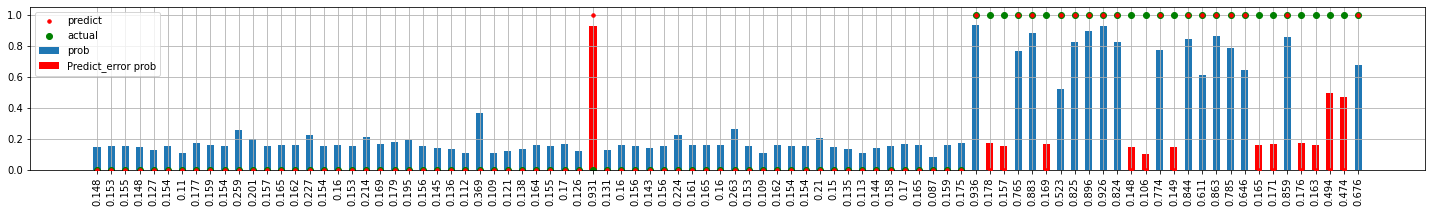

Train Score: 0.8373
Accuracy Score: 0.8556
confusion matrix: [[61  1]
 [12 16]]


In [11]:
from sklearn.svm import SVC
training(df_normal,SVC(probability=True))

LogisticRegression()
Your data is smaller than fig_amount_show's setting. 


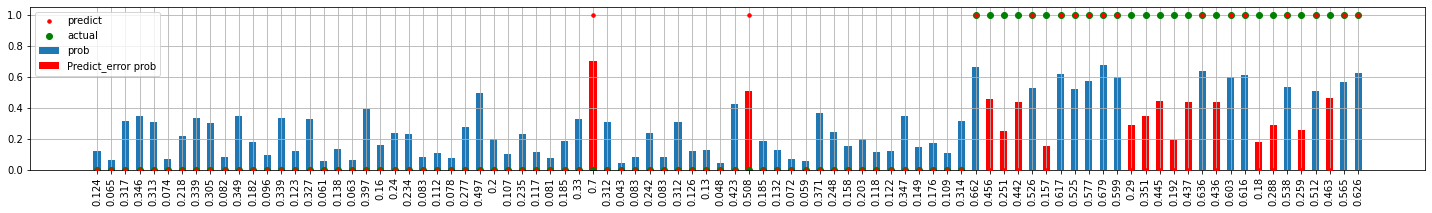

Train Score: 0.8421
Accuracy Score: 0.8222
confusion matrix: [[60  2]
 [14 14]]


In [12]:
from sklearn.linear_model import LogisticRegression
training(df_normal,LogisticRegression(),scaler='minmax')

KNeighborsClassifier()
Your data is smaller than fig_amount_show's setting. 


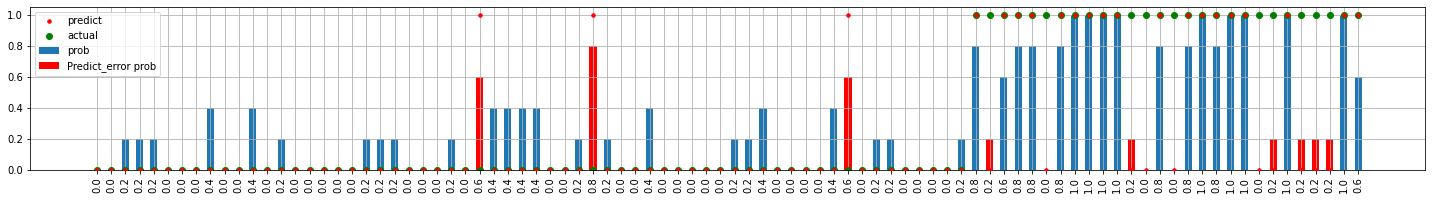

Train Score: 0.89
Accuracy Score: 0.8556
confusion matrix: [[59  3]
 [10 18]]


In [13]:
from sklearn.neighbors import KNeighborsClassifier
training(df_normal,KNeighborsClassifier())

DecisionTreeClassifier()
Your data is smaller than fig_amount_show's setting. 


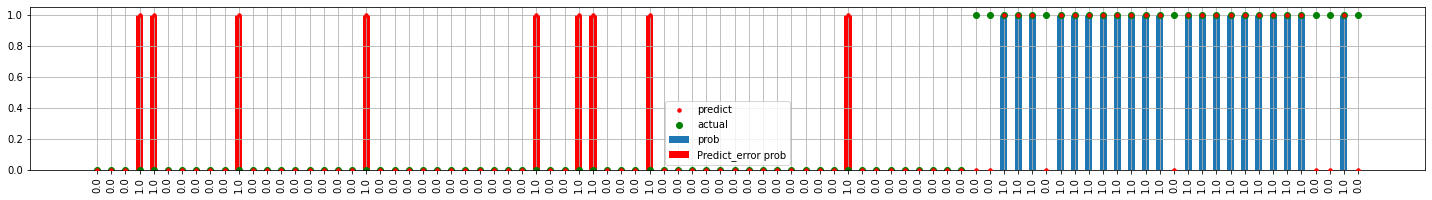

Train Score: 1.0
Accuracy Score: 0.8222
confusion matrix: [[53  9]
 [ 7 21]]


In [14]:
from sklearn.tree import DecisionTreeClassifier
training(df,DecisionTreeClassifier())

RandomForestClassifier()
Your data is smaller than fig_amount_show's setting. 


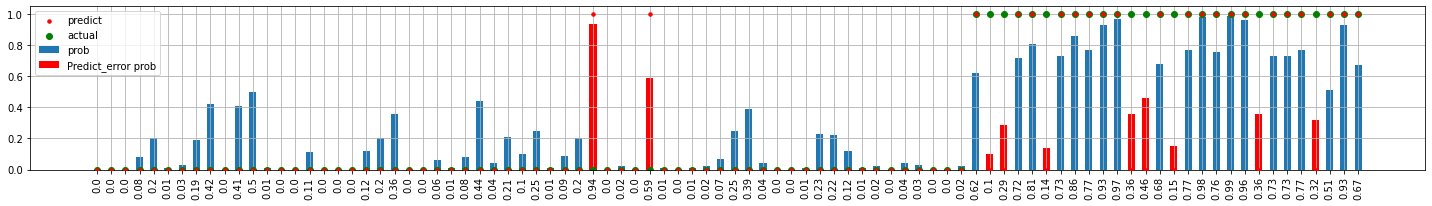

Train Score: 1.0
Accuracy Score: 0.8889
confusion matrix: [[60  2]
 [ 8 20]]


In [15]:
from sklearn.ensemble import RandomForestClassifier
training(df,RandomForestClassifier())

SGDClassifier(loss='modified_huber')
Your data is smaller than fig_amount_show's setting. 


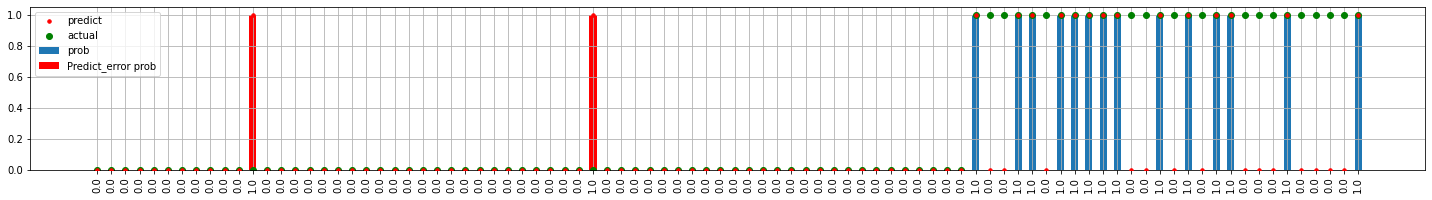

Train Score: 0.823
Accuracy Score: 0.8222
confusion matrix: [[60  2]
 [14 14]]


In [16]:
from sklearn.linear_model import SGDClassifier
training(df,SGDClassifier(loss='modified_huber'))

MLPClassifier()
Your data is smaller than fig_amount_show's setting. 


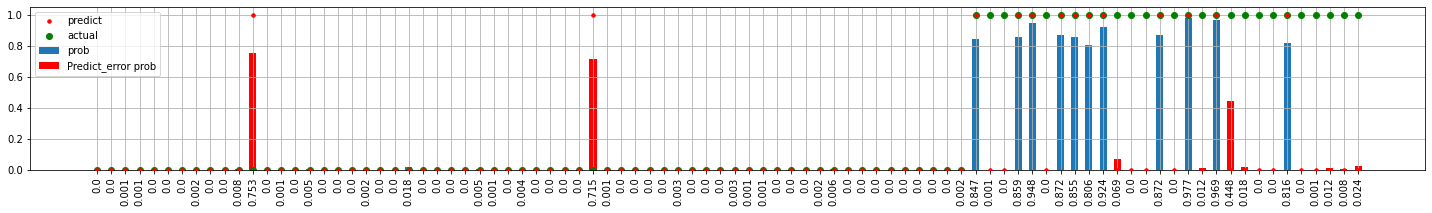

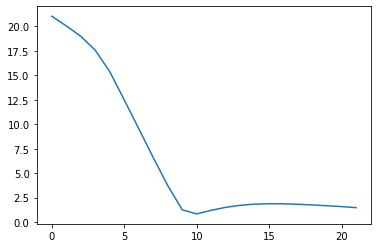

Train Score: 0.7895
Accuracy Score: 0.7889
confusion matrix: [[60  2]
 [17 11]]


In [17]:
from sklearn.neural_network import MLPClassifier
training(df,MLPClassifier())

## BOOSTING

AdaBoostClassifier()
Your data is smaller than fig_amount_show's setting. 


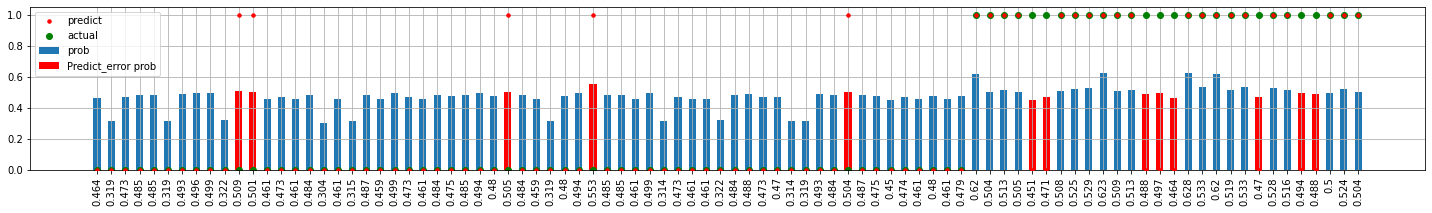

Train Score: 0.9091
Accuracy Score: 0.8556
confusion matrix: [[57  5]
 [ 8 20]]


In [18]:
from sklearn.ensemble import AdaBoostClassifier
training(df,AdaBoostClassifier())

XGBClassifier()
Your data is smaller than fig_amount_show's setting. 


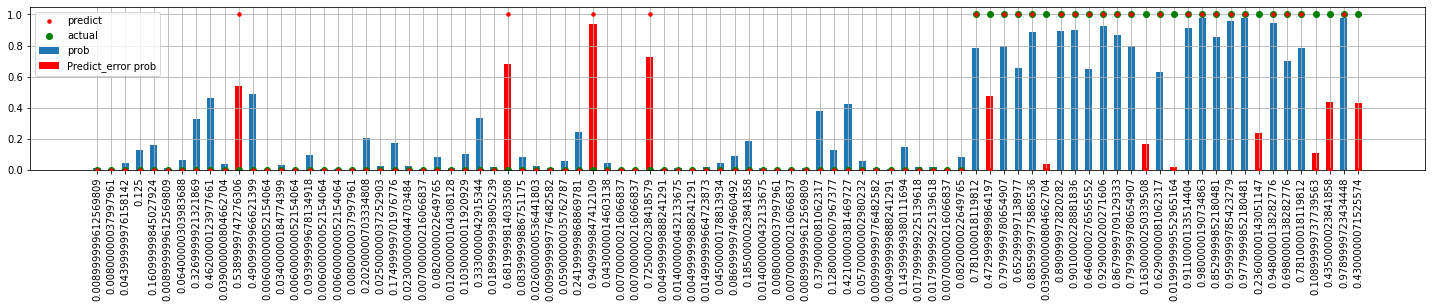

Train Score: 0.933
Accuracy Score: 0.8667
confusion matrix: [[58  4]
 [ 8 20]]


In [19]:
from xgboost.sklearn import XGBClassifier
training(df,XGBClassifier())

     |████████████████████████████████| 76.3 MB 1.1 MB/s 
Your data is smaller than fig_amount_show's setting. 


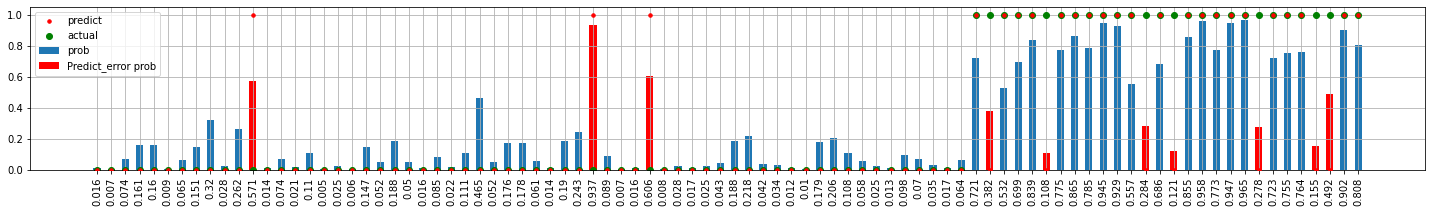

Train Score: 0.9378
Accuracy Score: 0.8889
confusion matrix: [[59  3]
 [ 7 21]]


In [20]:
!pip install catboost
from catboost import CatBoostClassifier
training(df,CatBoostClassifier(verbose=False))

## Bagging

BaggingClassifier(base_estimator=XGBClassifier(), n_estimators=100)
Your data is smaller than fig_amount_show's setting. 


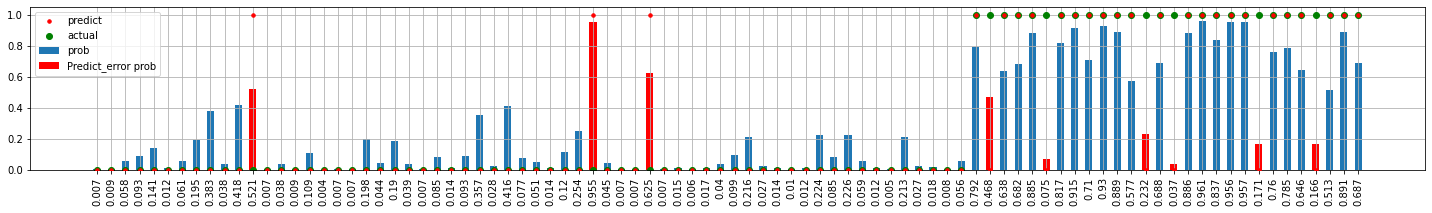

Train Score: 0.9282
Accuracy Score: 0.9
confusion matrix: [[59  3]
 [ 6 22]]


In [21]:
from sklearn.ensemble import BaggingClassifier
from xgboost.sklearn import XGBClassifier
clf=XGBClassifier()
training(df,BaggingClassifier(base_estimator=clf,n_estimators=100))